# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and reorientation the subset of such points (`outputSet`) that lie on the convex hull.

In [1]:
# TODO: convex hull of 1 point is the point itself, convex hull of 2 points is also the points themselves
# TODO: make sure to mention space complexity in report
# TODO: make sure to mention std, mean and median
# TODO: to improve readability, consider changing tuple[float, float] to Point (where Point is a class with x and y attributes)

In [2]:
import math

# Utility functions

def is_counter_clockwise(p1: tuple[float, float], p2: tuple[float, float], p3: tuple[float, float]) -> bool:
    # vector product to check if p3 is to the left of the line p1 -> p2
    area = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    return area > 0

def get_min_y_index(input_set: list[tuple[float, float]]) -> int:
    min_y = math.inf
    min_y_index = 0
    for i in range(len(input_set)):
        if input_set[i][1] < min_y:
            min_y = input_set[i][1]
            min_y_index = i
    return min_y_index

def distance(p1: tuple[float, int], p2: tuple[float, float]) -> float:
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

# def sort_by_polar_angle(p0: tuple[float, float], input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
#     input_set.sort(key=lambda p: math.atan2(p[1] - p0[1], p[0] - p0[0]))
#     return input_set

def partition(arr, low, high, p0):
    # Use a custom comparison considering p0 for angle calculation 
    def compare_by_angle(p):
        return math.atan2(p[1] - p0[1], p[0] - p0[0])

    pivot = compare_by_angle(arr[high])  # Compare by angle of pivot
    i = low - 1 
    for j in range(low, high):
        if compare_by_angle(arr[j]) <= pivot:  # Compare each point's angle
            i += 1
            arr[i], arr[j] = arr[j], arr[i]

    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return i + 1

def quick_sort(arr, low, high, p0):
    if low < high:
        pi = partition(arr, low, high, p0)
        quick_sort(arr, low, pi - 1, p0)
        quick_sort(arr, pi + 1, high, p0)

def sort_by_polar_angle(p0: tuple[float, float], input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    quick_sort(input_set, 0, len(input_set) - 1, p0)
    return input_set

points = [(1, 2), (3, 4), (2, 3), (-1, 1)]
origin = (0, 0)

def leftmost_point(points):
     # Return the point with the smallest x (and smallest y if necessary)
    return min(points)

def copy_points(points: list[tuple[float, float]]) -> list[tuple[float, float]]:
    return [point for point in points]

In [3]:
def jarvis_march(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    P = []  # Resulting convex hull
    i = 0

    while True:
        P.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        endpoint = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            if endpoint == point_on_hull or is_counter_clockwise(P[i], endpoint, input_set[j]):
                # Found a more counterclockwise point
                endpoint = input_set[j]

        i += 1  # Increment the index for the hull points list
        point_on_hull = endpoint

        # Check if we have wrapped around to the first point
        if endpoint == P[0]:
            break

    return P

In [4]:
def jarvis_march_terminate(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]] | None:
    # same as jarvis_march but terminates after m points
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    P = []  # Resulting convex hull
    i = 0


    for _ in range(m):
        P.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        endpoint = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            if endpoint == point_on_hull or is_counter_clockwise(P[i], endpoint, input_set[j]):
                # Found a more counterclockwise point
                endpoint = input_set[j]

        i += 1  # Increment the index for the hull points list
        point_on_hull = endpoint

        # Check if we have wrapped around to the first point
        if endpoint == P[0]:
            return P

    return None

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [5]:
def graham_scan(input_set: list[tuple[float, float]]) -> list[tuple[float, float]]:
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    if len(input_set) < 3:
        return input_set
    stack = []
    min_y_index = get_min_y_index(input_set)
    input_set[0], input_set[min_y_index] = input_set[min_y_index], input_set[0]
    p0 = input_set[0]
    sort_by_polar_angle(p0, input_set)
    stack.append(p0)
    stack.append(input_set[1])
    for i in range(2, len(input_set)):
        while len(stack) > 1 and not is_counter_clockwise(stack[-2], stack[-1], input_set[i]):
            stack.pop()
        stack.append(input_set[i])
    return stack

In [6]:
import matplotlib.pyplot as plt

def plot_points(input_set: list[tuple[float, float]], output_set: list[tuple[float, float]]) -> None:
    x = [i[0] for i in input_set]
    y = [i[1] for i in input_set]
    plt.scatter(x, y)
    x = [i[0] for i in output_set]
    y = [i[1] for i in output_set]
    # close the loop
    x.append(output_set[0][0])
    y.append(output_set[0][1])
    plt.plot(x, y)
    plt.show()

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [7]:
# TODO: could greatly benefit from keeping track of which hulls each point is in when choosing the next point

def partition_points(input_set: list[tuple[float, float]], num_partitions: int) -> list[list[tuple[float, float]]]:
    partition_size = math.ceil(len(input_set) / num_partitions)
    return [input_set[i:i + partition_size] for i in range(0, len(input_set), partition_size)]

def orientation(p: tuple[float, float], q: tuple[float, float], r: tuple[float, float]) -> int:
    # 0 -> colinear, 1 -> clockwise, -1 -> counterclockwise
    area = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if area == 0:
        return 0
    return 1 if area > 0 else -1

def find_tangent(p: tuple[float, float], hull: list[tuple[float, float]]) -> int:
    if len(hull) == 1:
        return 0
        
    n = len(hull)
    left, right = 0, n - 1

    left_before = orientation(p, hull[0], hull[-1])
    left_after = orientation(p, hull[0], hull[(left + 1) % n])

    while left < right:
        mid = (left + right) // 2

        mid_before = orientation(p, hull[mid], hull[abs(mid - 1) % n])
        mid_after = orientation(p, hull[mid], hull[(mid + 1) % n])
        mid_side = orientation(p, hull[left], hull[mid])
 
        if mid_before != -1 and mid_after != -1:
            return mid
        elif (mid_side == 1 and (left_after == -1 or left_before == left_after)) \
                or (mid_side == -1 and mid_before == -1):
            right = mid
        else:
            left = mid + 1
            left_before = -mid_after
            left_after = orientation(p, hull[left], hull[(left + 1) % n])
        
    return left

TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)
def _rtangent_(p, hull):
    """Return the index of the point in hull that the right tangent line from p
    to hull touches.
    """
    if len(hull) == 1:
        return 0
    
    l, r = 0, len(hull) - 1
    l_prev = orientation(p, hull[0], hull[-1])
    l_next = orientation(p, hull[0], hull[(l + 1) % r])
    while l < r:
        c = (l + r) // 2
        c_prev = orientation(p, hull[c], hull[abs(c - 1) % len(hull)])
        c_next = orientation(p, hull[c], hull[(c + 1) % len(hull)])
        c_side = orientation(p, hull[l], hull[c])
        if c_prev != TURN_RIGHT and c_next != TURN_RIGHT:
            return c
        elif c_side == TURN_LEFT and (l_next == TURN_RIGHT or
                                      l_prev == l_next) or \
                c_side == TURN_RIGHT and c_prev == TURN_RIGHT:
            r = c               # Tangent touches left chain
        else:
            l = c + 1           # Tangent touches right chain
            l_prev = -c_next    # Switch sides
            l_next = orientation(p, hull[l], hull[(l + 1) % len(hull)])
    return l

def visualize_convex_hulls(
        partitions: list[tuple[float, float]],
        hulls: list[list[tuple[float, float]]], 
    ) -> None:

    for i in range(len(hulls)):
        x = [i[0] for i in partitions[i]]
        y = [i[1] for i in partitions[i]]
        plt.scatter(x, y)
        x = [i[0] for i in hulls[i]]
        y = [i[1] for i in hulls[i]]
        # close the loop
        x.append(hulls[i][0][0])
        y.append(hulls[i][0][1])
        plt.plot(x, y)
        
    plt.show()

def get_hull_leftmost_point(hulls: list[list[tuple[float, float]]]) -> tuple[int, int]:
    # returns the index of the hull and the index of the leftmost point in the hull
    min_x = math.inf
    min_x_index = 0
    min_x_hull_index = 0
    for i in range(len(hulls)):
        for j in range(len(hulls[i])):
            if hulls[i][j][0] < min_x:
                min_x = hulls[i][j][0]
                min_x_index = j
                min_x_hull_index = i
    return min_x_hull_index, min_x_index

def _chan(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]] | None:
    hulls = [graham_scan(input_set[i:i + m]) for i in range(0, len(input_set), m)]

    # merge the convex hulls
    convex_hull = []

    next_hull_index, next_point_index = get_hull_leftmost_point(hulls)
    
    for _ in range(m + 1):
        convex_hull.append((next_hull_index, next_point_index))
        next_point = hulls[next_hull_index][next_point_index]
        end_hull_index = 0
        end_point_index = _rtangent_(next_point, hulls[0])

        for i in range(0, len(hulls)):
            if i == next_hull_index:
                j = (next_point_index - 1) % len(hulls[i])
            else:
                j = find_tangent(next_point, hulls[i])
                
            p = hulls[i][j]
            end_point = hulls[end_hull_index][end_point_index]
            if end_point == next_point or is_counter_clockwise(next_point, end_point, p):
                end_hull_index = i
                end_point_index = j

        next_hull_index = end_hull_index
        next_point_index = end_point_index

        if (next_hull_index, next_point_index) == convex_hull[0]:
            return [hulls[i][j] for i, j in convex_hull]
        
    return None

def chan(input_set: list[tuple[float, float]]) -> list[tuple[float, float]] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan(input_set, m)
        if output_set is not None:
            return output_set
        m = min(m * m, n)
        
    return None

In [8]:
def _chan_simple(input_set: list[tuple[float, float]], m: int) -> list[tuple[float, float]] | None:
    # partitions = partition_points(input_set, m)
    
    # find convex hulls of each partition
    hulls = [graham_scan(input_set[i:i + m]) for i in range(0, len(input_set), m)]
    
    # call jarvis_marsh_terminate on the flattened hulls
    return jarvis_march_terminate([point for hull in hulls for point in hull], m)

def chan_simple(input_set: list[tuple[float, float]]) -> list[tuple[float, float]] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    n = len(input_set)

    if n < 3:
        return input_set
    
    m = 3
    while m < n:
        output_set = _chan_simple(input_set, m)
        if output_set is not None:
            return output_set
        m = min(m * m, n)
        
    return None

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [9]:
import random

# TODO: revise the randomness of the data generation, for example have a Random generator
class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """

    def __init__(self, seed: int | None = None):
        self._rng = random.Random(seed)

    def set_seed(self, seed: int) -> None:
        self._rng.seed(seed)

    def generate_colinear_points(self, test_size: int) -> list[tuple[float, float]]:
        points = []
        slope = random.randint(-5,5)
        intercept = random.randint(-10,10)
        for _ in range(test_size):
            x = random.gauss(0,1)
            y = slope * x + intercept
            points.append((x, y))
        return points

    def generate_concentric_circles(self, test_size: int) -> list[tuple[float, float]]:
        list_of_points = []
        for _ in range(test_size):
            x = self._rng.uniform(-1, 1)
            list_of_points.append((x, math.sqrt(1 - x**2) * self._rng.choice([1, -1])))
        return list_of_points
    
    def generate_filled_disk(self, test_size: int) -> list[tuple[float, float]]:
        list_of_points = []
        # generate points around the unit circle
        for _ in range(test_size // 2):
            x = self._rng.uniform(-1, 1)
            list_of_points.append((x, math.sqrt(1 - x**2) * self._rng.choice([1, -1])))

        # generate points inside the unit circle
        for _ in range(test_size // 2):
            x = self._rng.uniform(-1, 1)
            y = self._rng.uniform(-1, 1)
            if x**2 + y**2 < 1:
                list_of_points.append((x, y))
        return list_of_points

    def generate_random_points(self, test_size: int) -> list[tuple[int, int]]:
        return [(self._rng.gauss(0, 1), self._rng.gauss(0, 1)) for _ in range(test_size)]
        
    def generate_random_points_with_outliers(self, num_points=100):
       random_points = [(self._rng.gauss(0, 1), self._rng.gauss(0, 1)) for _ in range(num_points)]
       outliers = []
       for _ in range(3):
           outliers.append((self._rng.uniform(-20, 20), self._rng.uniform(-20, 20)))  
       points_with_outliers = random_points + outliers
       return points_with_outliers
    
    def generate_random_points_with_outliers_v2(self, test_size: int) -> list[tuple[int, int]]:
        points = []
        i = 0
        while i < test_size - 3:
            x = random.gauss(0, 1)
            y = random.gauss(0, 1)
            if x**2 + y**2 < 1:
                points.append((x, y))
                i += 1
        
        # adding triangle outliers
        points.append((0, 2))
        points.append((math.sqrt(3), -1))
        points.append((-math.sqrt(3), -1))

        return points
    
    def generate_points(self, num_convex_hull_vertices: int, num_points: int) -> list[tuple[int, int]]:
        if num_convex_hull_vertices > num_points:
            raise ValueError("The number of convex hull vertices should be less than or equal to the number of points")
        
        if num_convex_hull_vertices == 1:
            assert num_points == 1
            return self.generate_random_points(1)
        
        if num_convex_hull_vertices == 2:
            return self.generate_colinear_points(num_points)

        points = []
        # adding inscribed triangle
        points.append((0, 2))
        points.append((math.sqrt(3), -1))
        points.append((-math.sqrt(3), -1)) 

        # adding the rest of the outer points
        RADIUS = 2
        for _ in range(num_convex_hull_vertices - 3):
            angle = 2 * math.pi * random.random()
            x = RADIUS * math.cos(angle)
            y = RADIUS * math.sin(angle)
            points.append((x, y))
        
        # adding the inner points
        num_inner_points = num_points - num_convex_hull_vertices
        i = 0
        while i < num_inner_points:
            x = random.gauss(0, 1)
            y = random.gauss(0, 1)
            if x**2 + y**2 < 1: # inside the unit circle
                points.append((x, y))
                i += 1
        
        # shuffle the points
        self._rng.shuffle(points)
        
        return points
        
        


Use the cell below to implement the requested **experimental framework** API.

In [10]:
import timeit

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    Attributes
    ----------

    experiment_name : str
        the name of the experiment
    functions : dict
        a dictionary of algorithms to be tested
    results : dict
        a dictionary of results

    Methods
    -------
    add_algorithm(algorithm: callable, name: str)
        Adds an algorithm to the dictionary of algorithms
    run_experiment(input_set: list[tuple[float, float]])
        Runs the experiment on the input set
    visualize_results()
        Visualizes the results of the experiment
    """ 
    
    def __init__(self, experiment_name: str):
        self.experiment_name = experiment_name
        self.independent_variable = "Input size"
        self.algorithms = {}  
        self.means = {}
        self.stds = {}
        self.trials_per_run = 1

    def set_independent_variable(self, variable: str):
        self.independent_variable = variable

    def set_trials_per_run(self, trials: int):
        self.trials_per_run = trials

    def add_algorithm(self, name: str, algorithm):
        self.algorithms[name] = algorithm
        self.means[name] = []
        self.stds[name] = []

    def run_experiment(self, variable: int, input_set: list[tuple[float, float]]):
        for name in self.algorithms:
            times_taken = []
            for _ in range(self.trials_per_run):
                # points are copied to avoid having a modified input_set in following trials
                trial_time = timeit.timeit(lambda: self.algorithms[name](copy_points(input_set)), number=1)
                times_taken.append(trial_time)
    
            mean_time = sum(times_taken) / self.trials_per_run
            std_time = math.sqrt(sum((time - mean_time) ** 2 for time in times_taken) / self.trials_per_run)

            self.means[name].append((variable, mean_time))
            self.stds[name].append((variable, std_time))

    def visualize_means(self):
        plt.figure()
        for name in self.means:
            x = [i[0] for i in self.means[name]]
            y = [i[1] for i in self.means[name]]
            plt.plot(x, y, label=name)
        plt.xlabel(self.independent_variable)
        plt.ylabel(f"Average Time Taken (n={self.trials_per_run})")
        plt.title(self.experiment_name)
        plt.legend()
        plt.show()

    # temporary method to visualize the standard deviations
    # TODO: figure out how to present the standard deviations in the report
    def visualize_stds(self):
        plt.figure()
        for name in self.stds:
            x = [i[0] for i in self.stds[name]]
            y = [i[1] for i in self.stds[name]]
            plt.plot(x, y, label=name)
        plt.xlabel(self.independent_variable)
        plt.ylabel(f"Standard Deviation of Time Taken (n={self.trials_per_run})")
        plt.title(self.experiment_name)
        plt.legend()
        plt.show()
        

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [12]:
# Chan's Convex Hull O(n log h) - Tom Switzer <thomas.switzer@gmail.com>

TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)

def turn(p, q, r):
    """Returns -1, 0, 1 if p,q,r forms a right, straight, or left turn."""
    return orientation(p, q, r)

def _rtangent(hull, p):
    """Return the index of the point in hull that the right tangent line from p
    to hull touches.
    """
    if len(hull) == 1:
        return 0
    
    l, r = 0, len(hull) - 1
    l_prev = turn(p, hull[0], hull[-1])
    l_next = turn(p, hull[0], hull[(l + 1) % r])
    while l < r:
        c = (l + r) // 2
        c_prev = turn(p, hull[c], hull[abs(c - 1) % len(hull)])
        c_next = turn(p, hull[c], hull[(c + 1) % len(hull)])
        c_side = turn(p, hull[l], hull[c])
        if c_prev != TURN_RIGHT and c_next != TURN_RIGHT:
            return c
        elif c_side == TURN_LEFT and (l_next == TURN_RIGHT or
                                      l_prev == l_next) or \
                c_side == TURN_RIGHT and c_prev == TURN_RIGHT:
            r = c               # Tangent touches left chain
        else:
            l = c + 1           # Tangent touches right chain
            l_prev = -c_next    # Switch sides
            l_next = turn(p, hull[l], hull[(l + 1) % len(hull)])
    return l
    
def _next_hull_pt_pair(hulls, pair):
    """
    Returns the (hull, point) index pair of the next point in the convex
    hull.
    """
    p = hulls[pair[0]][pair[1]]
    next = (pair[0], (pair[1] - 1) % len(hulls[pair[0]]))
    for h in (i for i in range(len(hulls)) if i != pair[0]):
        s = _rtangent(hulls[h], p)
        q, r = hulls[next[0]][next[1]], hulls[h][s]
        t = orientation(p, q, r)
        if t == TURN_RIGHT or t == TURN_NONE and distance(p, r) > distance(p, q):
            next = (h, s)
    return next

def _min_hull_pt_pair(hulls):
    """Returns the hull, point index pair that is minimal."""
    h, p = 0, 0
    for i in range(len(hulls)):
        j = min(range(len(hulls[i])), key=lambda j: hulls[i][j])
        if hulls[i][j] < hulls[h][p]:
            h, p = i, j
    return (h, p)

def convex_hull(pts):
    """Returns the points on the convex hull of pts in CCW order."""
    if len(pts) < 3:
        return pts
    
    m = 3
    while m < len(pts):
        hulls = [graham_scan(pts[i:i + m]) for i in range(0, len(pts), m)]
        hull = [_min_hull_pt_pair(hulls)]
        for _ in range(m):
            p = _next_hull_pt_pair(hulls, hull[-1])
            if p == hull[0]:
                return [hulls[h][i] for h, i in hull]
            hull.append(p)
        m = min(m * m, len(pts))

In [13]:
# TODO: fixme, doesn't work on input_set = data_generator.generate_points(10, 1000) when points aren't shuffled properly
# shuffling makes it work sometimes, but this could be a sign of a deeper issue
data_generator = TestDataGenerator(seed=1)
for i in range(101, 1000):
    # test if convex_hull is equal to grahams_scan (ground truth)
    input_set = data_generator.generate_points(12, i)
    output_set = chan(copy_points(input_set))
    ground_truth = graham_scan(copy_points(input_set))
    output_set.sort()
    ground_truth.sort()
    if output_set != ground_truth:
        print(f"Convex hulls are not equal for n={i}")
        print("Convex hulls are not equal")
        print(output_set)
        print(ground_truth)
        break

# test only chan

# for algorithm in [jarvis_march, graham_scan, chan, chan_simple]:
    # print(algorithm.__name__)
    # plot_points(input_set, algorithm(copy_points(input_set)))

Finished running experiment for 100000 points


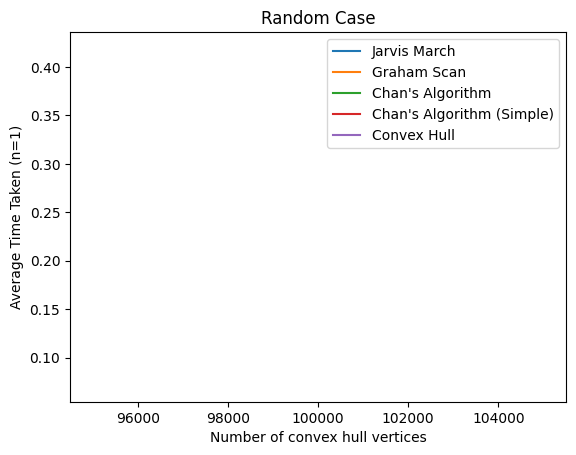

Finished running experiment for 120000 points


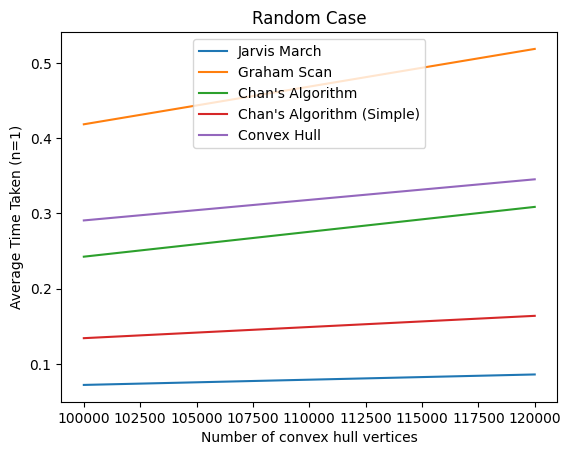

Finished running experiment for 140000 points


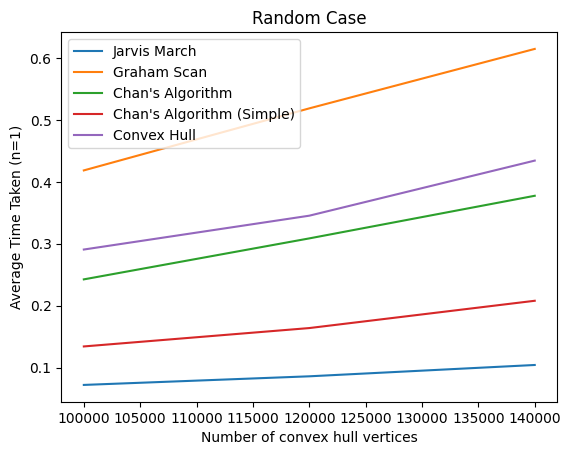

Finished running experiment for 160000 points


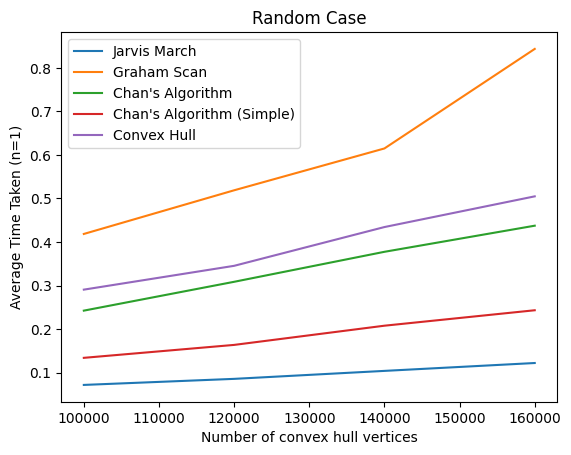

Finished running experiment for 180000 points


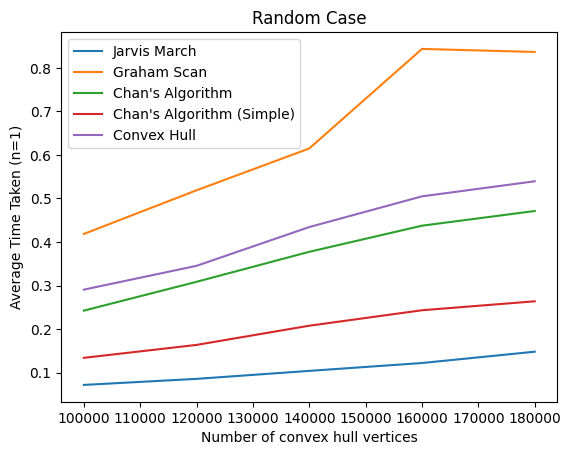

Finished running experiment for 200000 points


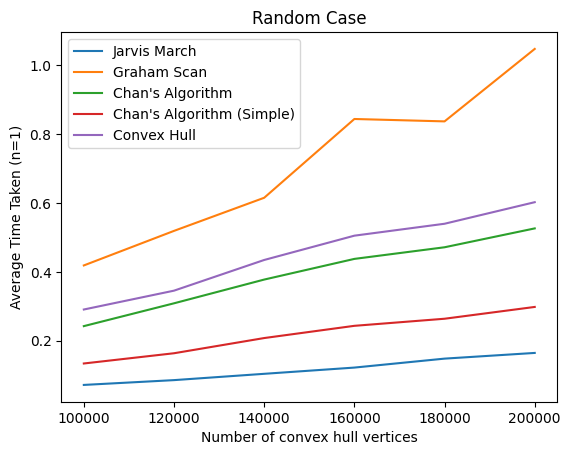

Finished running experiment for 220000 points


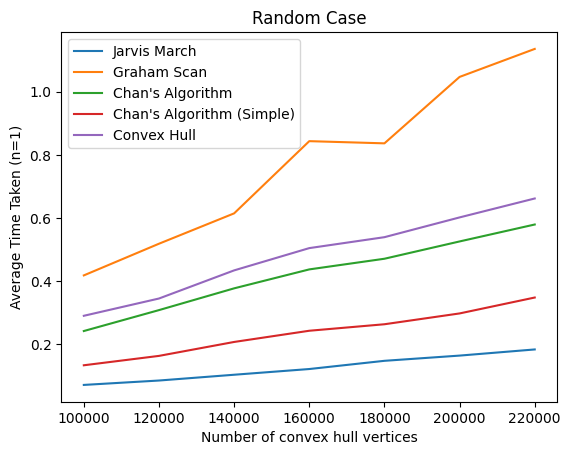

Finished running experiment for 240000 points


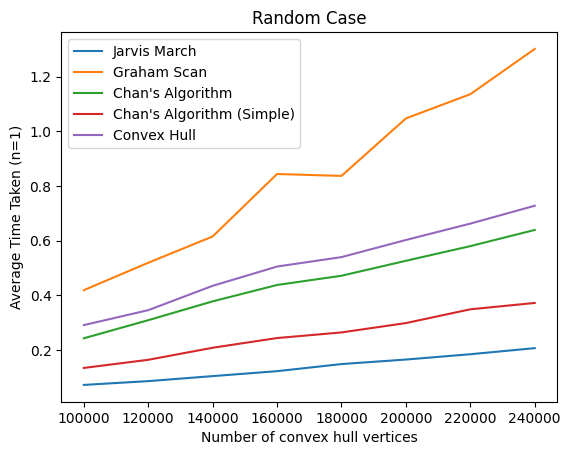

Finished running experiment for 260000 points


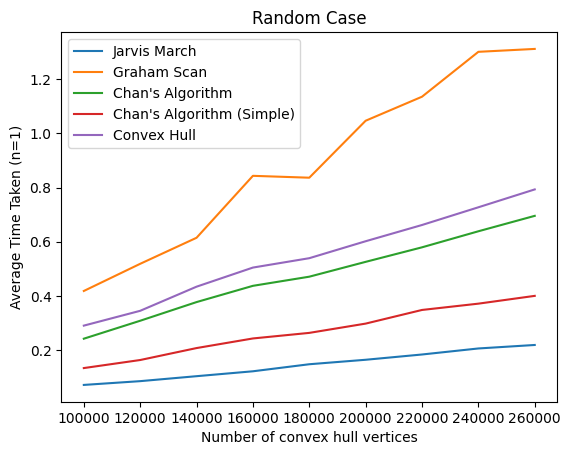

Finished running experiment for 280000 points


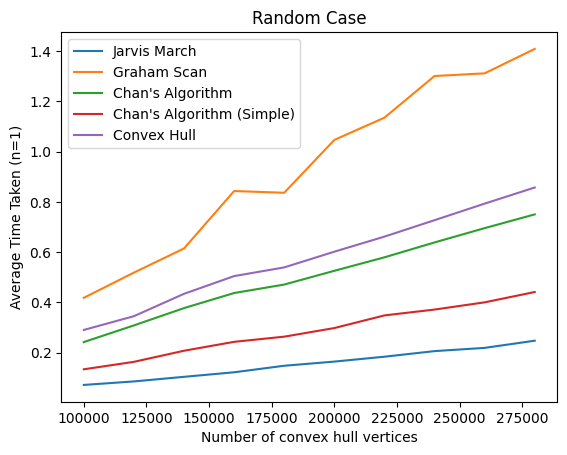

Finished running experiment for 300000 points


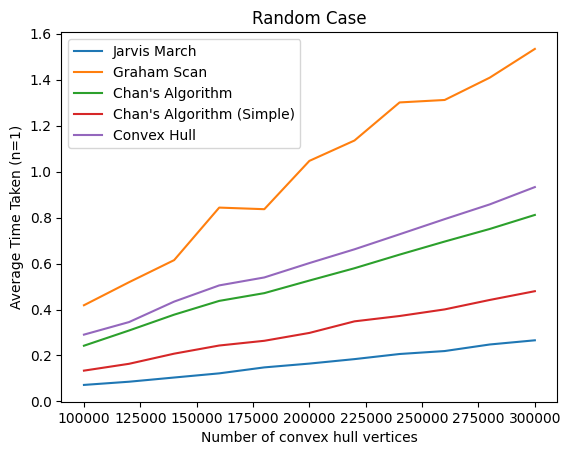

Finished running experiment for 320000 points


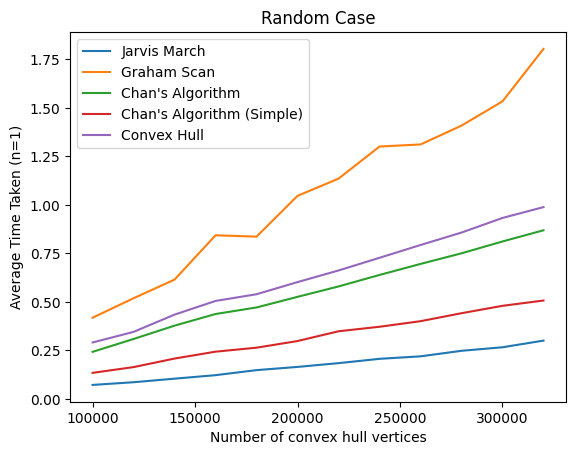

Finished running experiment for 340000 points


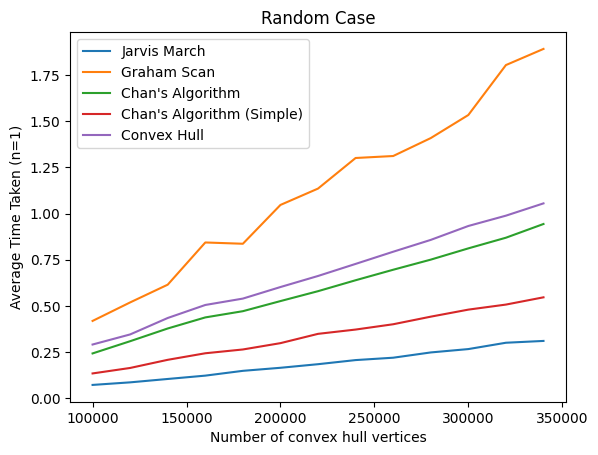

Finished running experiment for 360000 points


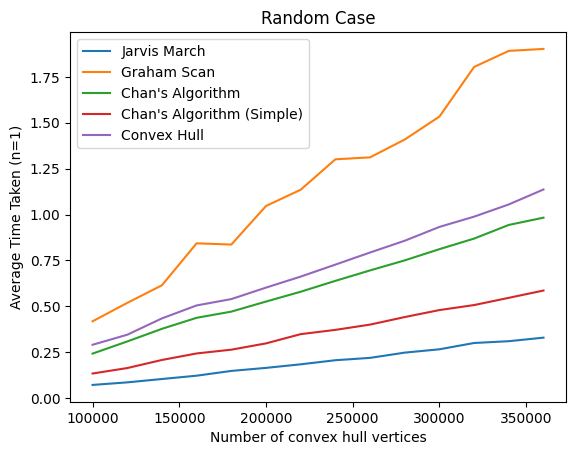

Finished running experiment for 380000 points


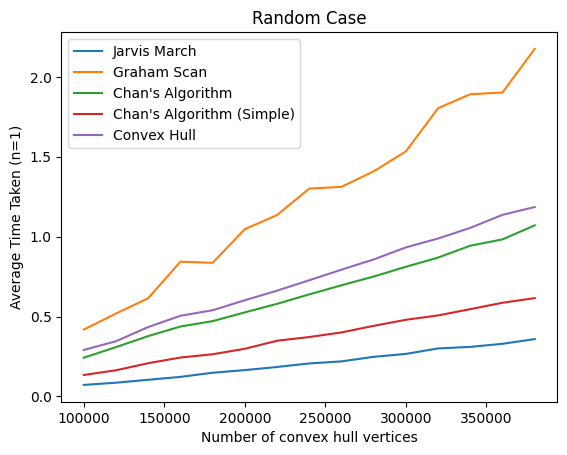

Finished running experiment for 400000 points


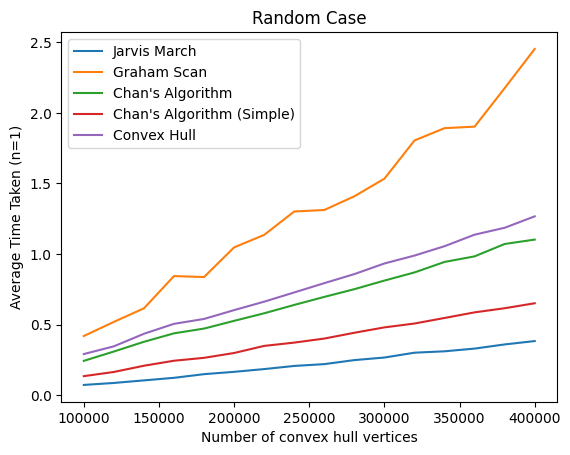

Finished running experiment for 420000 points


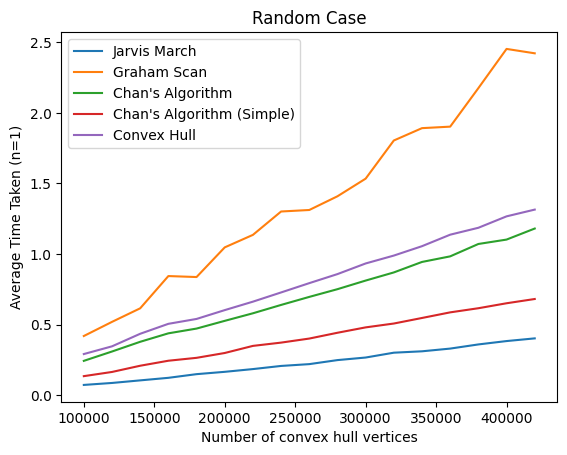

Finished running experiment for 440000 points


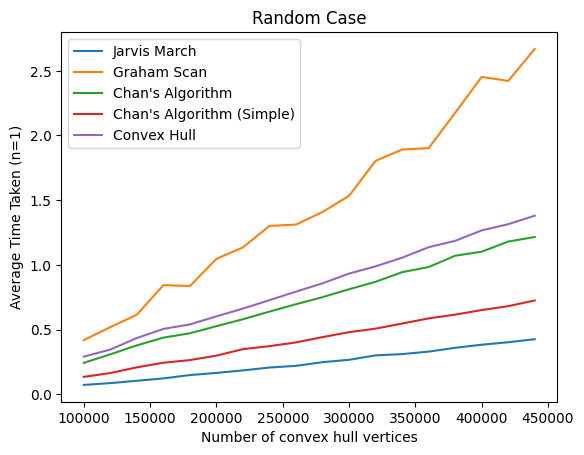

Finished running experiment for 460000 points


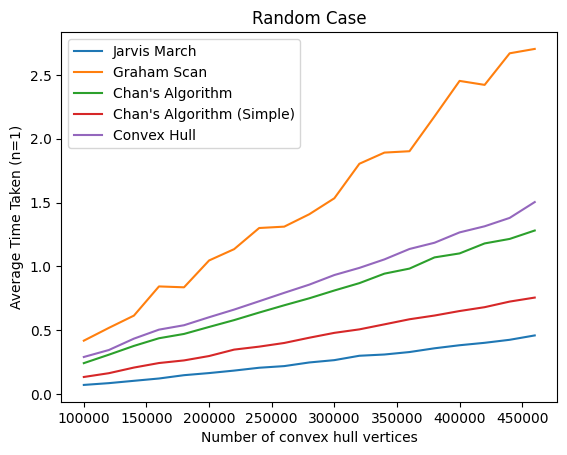

Finished running experiment for 480000 points


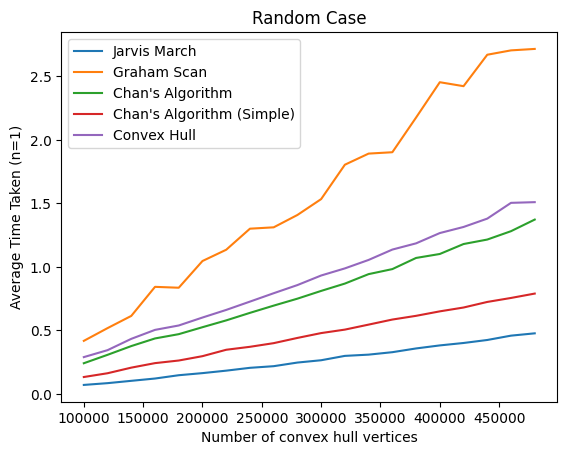

Finished running experiment for 500000 points


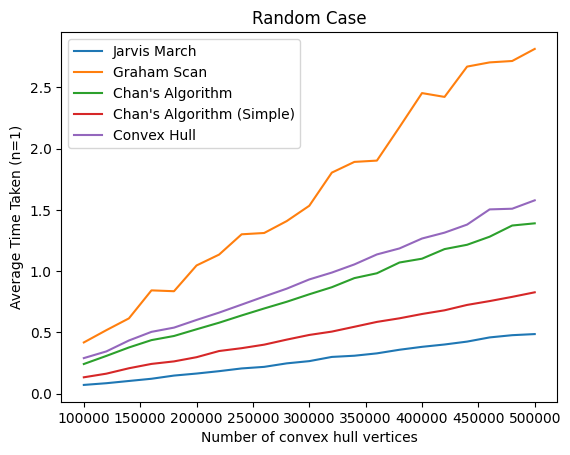

Finished running experiment for 520000 points


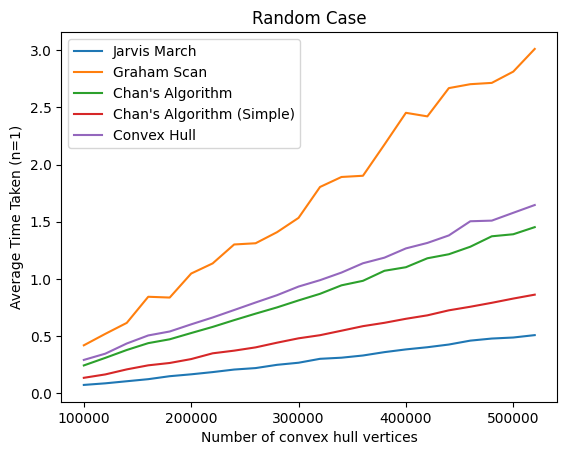

Finished running experiment for 540000 points


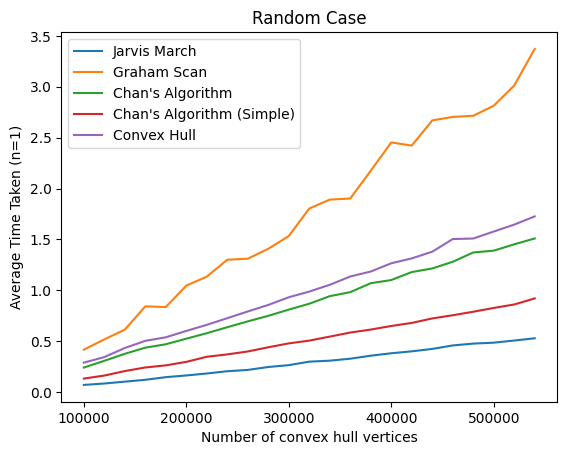

Finished running experiment for 560000 points


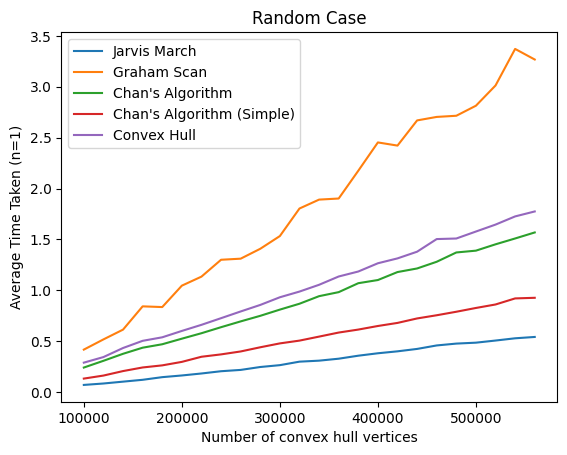

Finished running experiment for 580000 points


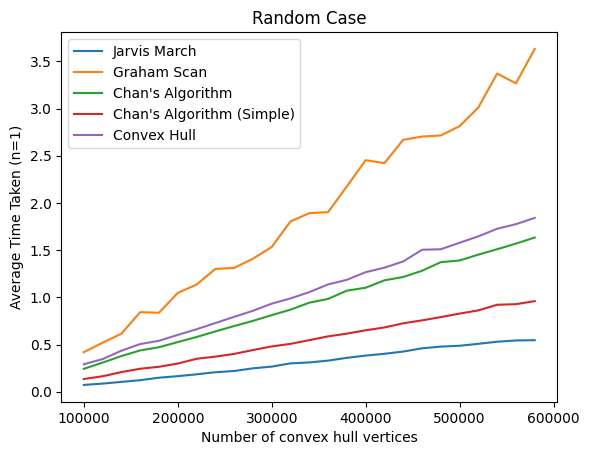

Finished running experiment for 600000 points


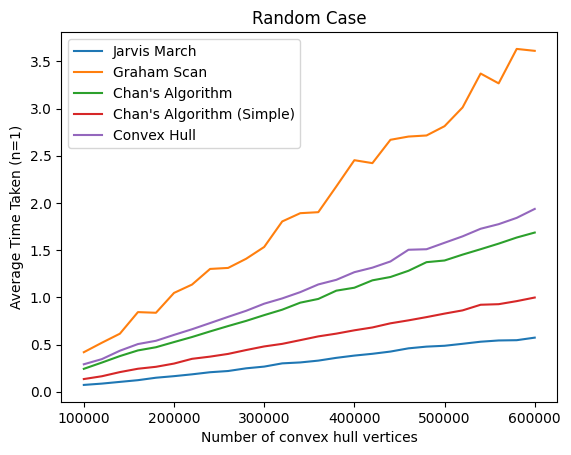

In [15]:
# Create an instance of the ExperimentalFramework class
experiment = ExperimentalFramework("Random Case")
experiment.set_independent_variable("Number of convex hull vertices")
experiment.set_trials_per_run(1)

# Add the algorithms to the experimental framework
experiment.add_algorithm("Jarvis March", jarvis_march)
experiment.add_algorithm("Graham Scan", graham_scan)
experiment.add_algorithm("Chan's Algorithm", chan)
experiment.add_algorithm("Chan's Algorithm (Simple)", chan_simple)
experiment.add_algorithm("Convex Hull", convex_hull)
# experiment.add_algorithm("Convex Hull", convex_hull)

# Run the experiment
data_generator = TestDataGenerator()
start = 100_000
end = 1_500_000
step = 20_000
for i in range(start, end, step):
    input_set = data_generator.generate_points(3, i)
    experiment.run_experiment(i, input_set)

    if (i - start) % 10_000 == 0:
        print(f"Finished running experiment for {i} points")
        experiment.visualize_means()

In [ ]:
# Visualize the results
experiment.visualize_means()
experiment.visualize_stds()